#pips

In [ ]:
!pip install openpyxl
!pip install pygam


#Libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib


#Data

In [2]:
data = joblib.load('/content/drive/MyDrive/Bankruptcy Prediction Data/Prepared Dataset for Thesis/Dataset.pkl')
print(data.head())

X = data.drop(columns=['result'])
y = data['result']

   Profitability Ratios (Return from Sales) EBIT/Sales last avail. Year  \
0                                           1.281861                      
1                                           0.022043                      
2                                           3.210585                      
3                                          51.385155                      
4                                          37.085847                      

   Profitability Ratios (Return from Sales) EBIT/Sales last year -1  \
0                                          -0.073507                  
1                                          -0.027587                  
2                                          -2.198620                  
3                                          -2.196863                  
4                                          -2.354131                  

   Profitability Ratios (Return from Sales) EBIT/Sales last year -2  \
0                                           0.03703

In [3]:
data.shape

(255919, 61)

In [4]:

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Models

In [5]:

models = {
    "Quadratic Discriminant Analysis (QDA)": QuadraticDiscriminantAnalysis(reg_param=0.1)
  }




#Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
cv_results = {model_name: [] for model_name in models.keys()}
roc_curves_cv = {model_name: [] for model_name in models.keys()}
pr_curves_cv = {model_name: [] for model_name in models.keys()}

#Fitting models and Evaluations

Training Quadratic Discriminant Analysis (QDA) with Cross-Validation
Mean Threshold for Quadratic Discriminant Analysis (QDA): 0.10

Cross-validation Metrics for Quadratic Discriminant Analysis (QDA):
  Fold 1:
    Accuracy: 0.8692
    Precision: 0.4254
    Recall: 0.5145
    F1: 0.4657
    ROC AUC: 0.8801
    PR AUC: 0.4549
    Class Accuracies: {'non_bankrupt': 0.9133854807523291, 'bankrupt': 0.514456981664316}
  Fold 2:
    Accuracy: 0.8658
    Precision: 0.4177
    Recall: 0.5360
    F1: 0.4695
    ROC AUC: 0.8734
    PR AUC: 0.4531
    Class Accuracies: {'non_bankrupt': 0.9068817015292671, 'bankrupt': 0.535966149506347}
  Fold 3:
    Accuracy: 0.8732
    Precision: 0.4342
    Recall: 0.4743
    F1: 0.4533
    ROC AUC: 0.8765
    PR AUC: 0.4546
    Class Accuracies: {'non_bankrupt': 0.9229653717700826, 'bankrupt': 0.4742595204513399}
  Fold 4:
    Accuracy: 0.8723
    Precision: 0.4317
    Recall: 0.4817
    F1: 0.4553
    ROC AUC: 0.8748
    PR AUC: 0.4497
    Class Accuracies: {'

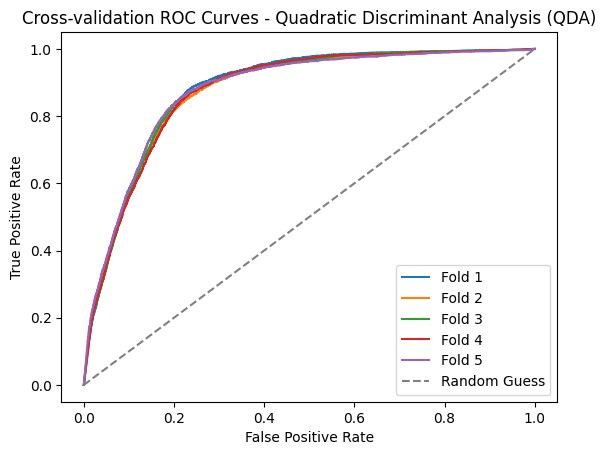

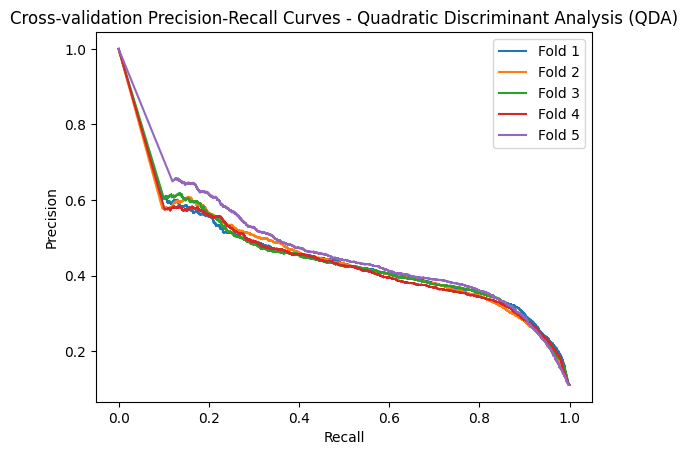


Final Training for Quadratic Discriminant Analysis (QDA)

Final Metrics for Quadratic Discriminant Analysis (QDA):
  Accuracy: 0.8708
  Precision: 0.4299
  Recall: 0.5089
  F1 Score: 0.4661
  ROC AUC: 0.8767
  PR AUC: 0.4628
  Class Accuracies: {'non_bankrupt': 0.9158991035331341, 'bankrupt': 0.508885754583921}


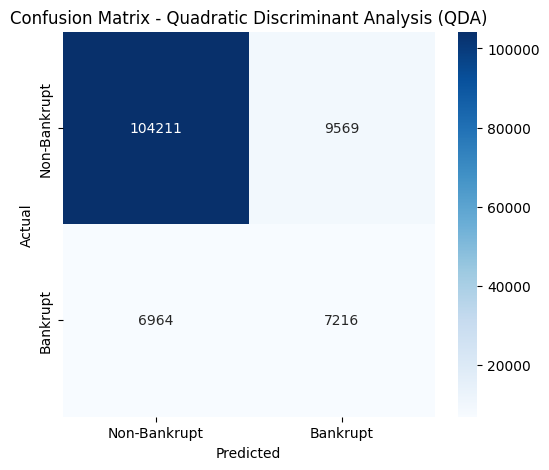

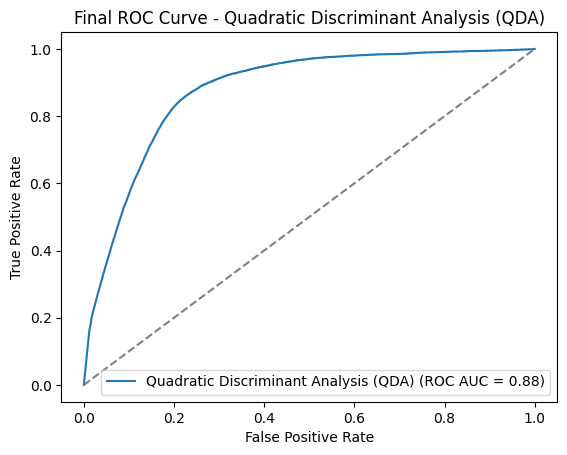

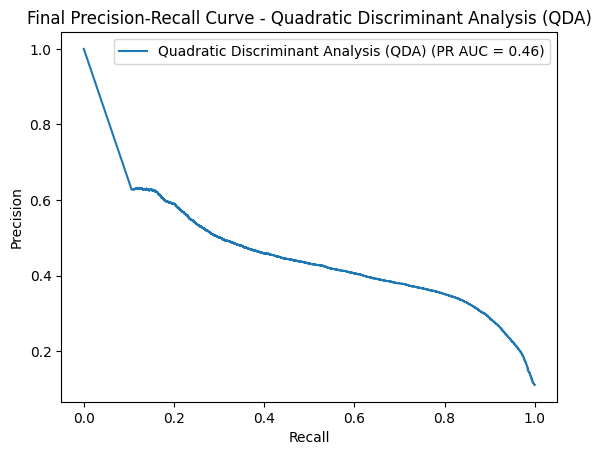

In [ ]:
for model_name, model in models.items():
    print(f"Training {model_name} with Cross-Validation")
    thresholds = []

    for fold_idx, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train.values[train_index], y_train.values[val_index]

        model.fit(X_fold_train, y_fold_train)

        y_fold_proba = model.predict_proba(X_fold_val)[:, 1]
        best_threshold = 0.5
        best_f1 = 0

        for threshold in np.arange(0.1, 1.0, 0.01):
            y_fold_pred = (y_fold_proba >= threshold).astype(int)
            f1 = f1_score(y_fold_val, y_fold_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        thresholds.append(best_threshold)

        y_fold_pred = (y_fold_proba >= best_threshold).astype(int)

        # Metrics
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        precision = precision_score(y_fold_val, y_fold_pred)
        recall = recall_score(y_fold_val, y_fold_pred)
        f1 = f1_score(y_fold_val, y_fold_pred)
        roc_auc = roc_auc_score(y_fold_val, y_fold_proba)

        conf_matrix = confusion_matrix(y_fold_val, y_fold_pred)
        class_acc = {
            "non_bankrupt": conf_matrix[0, 0] / conf_matrix[0].sum(),
            "bankrupt": conf_matrix[1, 1] / conf_matrix[1].sum()
        }
        pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_fold_val, y_fold_proba)
        pr_auc = auc(pr_curve_recall, pr_curve_precision)

        cv_results[model_name].append({
            "Fold": fold_idx + 1,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "ROC AUC": roc_auc,
            "PR AUC": pr_auc,
            "Class Accuracies": class_acc
        })

        #curves
        fpr, tpr, _ = roc_curve(y_fold_val, y_fold_proba)
        roc_curves_cv[model_name].append((fpr, tpr))
        pr_curves_cv[model_name].append((pr_curve_precision, pr_curve_recall))

    #mean threshold
    mean_threshold = np.mean(thresholds)
    print(f"Mean Threshold for {model_name}: {mean_threshold:.2f}")

# Display Cross-validation Metrics
for model_name in models.keys():
    print(f"\nCross-validation Metrics for {model_name}:")
    for fold_metrics in cv_results[model_name]:
        print(f"  Fold {fold_metrics['Fold']}:")
        for metric, value in fold_metrics.items():
            if metric != "Fold" and metric != "Class Accuracies":
                print(f"    {metric}: {value:.4f}")
        print(f"    Class Accuracies: {fold_metrics['Class Accuracies']}")

    # Plot cross-validation ROC and PR curves
    plt.figure()
    for fold_idx, (fpr, tpr) in enumerate(roc_curves_cv[model_name]):
        plt.plot(fpr, tpr, label=f"Fold {fold_idx + 1}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.title(f"Cross-validation ROC Curves - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    plt.figure()
    for fold_idx, (precision, recall) in enumerate(pr_curves_cv[model_name]):
        plt.plot(recall, precision, label=f"Fold {fold_idx + 1}")
    plt.title(f"Cross-validation Precision-Recall Curves - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# Final Model Training and Evaluation
final_results = {}
roc_curves_final = {}
pr_curves_final = {}

for model_name, model in models.items():
    print(f"\nFinal Training for {model_name}")
    model.fit(X_train, y_train)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Use the mean threshold from CV
    mean_threshold = np.mean(thresholds)
    y_test_pred = (y_test_proba >= mean_threshold).astype(int)

    # Metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_acc = {
        "non_bankrupt": conf_matrix[0, 0] / conf_matrix[0].sum(),
        "bankrupt": conf_matrix[1, 1] / conf_matrix[1].sum()
    }
    pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_test, y_test_proba)
    pr_auc = auc(pr_curve_recall, pr_curve_precision)

    # Save results
    final_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Class Accuracies": class_acc
    }

    # Display final metrics
    print(f"\nFinal Metrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  PR AUC: {pr_auc:.4f}")
    print(f"  Class Accuracies: {class_acc}")

     # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Bankrupt', 'Bankrupt'],
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save final curves
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_curves_final[model_name] = (fpr, tpr)
    pr_curves_final[model_name] = (pr_curve_precision, pr_curve_recall)

    # Plot final curves
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"Final ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(pr_curve_recall, pr_curve_precision, label=f"{model_name} (PR AUC = {pr_auc:.2f})")
    plt.title(f"Final Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()






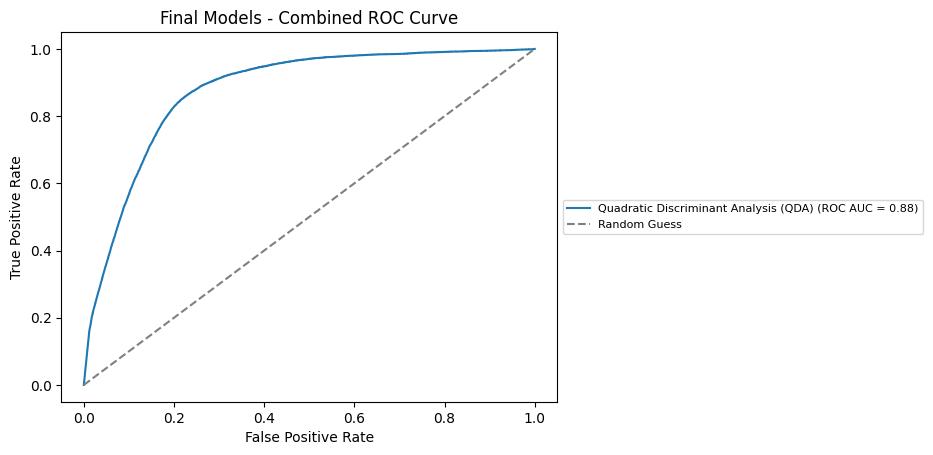

In [ ]:
# Combined ROC Curve for Final Models
plt.figure()
for model_name, (fpr, tpr) in roc_curves_final.items():
    plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC = {final_results[model_name]['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Final Models - Combined ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#Saving fit models

Saving

In [ ]:
import joblib
import os
os.makedirs("saved_models", exist_ok=True)
for model_name, model in models.items():
    model_path = f"/content/drive/MyDrive/Bankruptcy Prediction Data/SCRIPTS/Saved fit models/{model_name}.pkl"
    joblib.dump(model, model_path)



In [6]:
import os
loaded_models = {}
for model_name in models.keys():
    model_path = f"/content/drive/MyDrive/Bankruptcy Prediction Data/SCRIPTS/Saved fit models/{model_name}.pkl"
    if os.path.exists(model_path):
        loaded_models[model_name] = joblib.load(model_path)
        print(f"{model_name} loaded from {model_path}.")
    else:
        print(f"{model_name} not found in {model_path}, please train the model.")


Quadratic Discriminant Analysis (QDA) loaded from /content/drive/MyDrive/Bankruptcy Prediction Data/SCRIPTS/Saved fit models/Quadratic Discriminant Analysis (QDA).pkl.


#Loading results saved


Evaluating Quadratic Discriminant Analysis (QDA) on Test Data

Metrics for Quadratic Discriminant Analysis (QDA):
  Accuracy: 0.8813
  Precision: 0.4589
  Recall: 0.3987
  F1 Score: 0.4267
  ROC AUC: 0.8767
  PR AUC: 0.4628
  Class Accuracies: {'non_bankrupt': 0.9414044647565477, 'bankrupt': 0.3987306064880113}


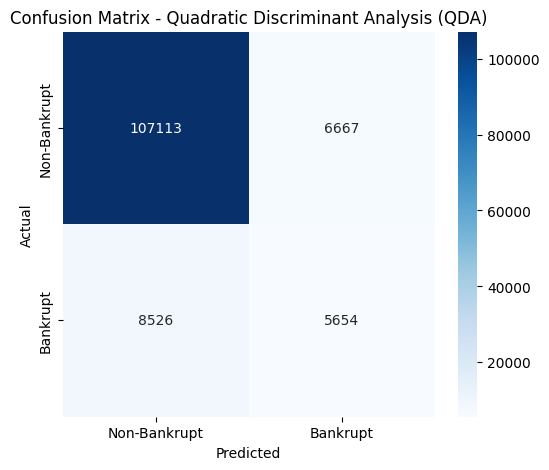

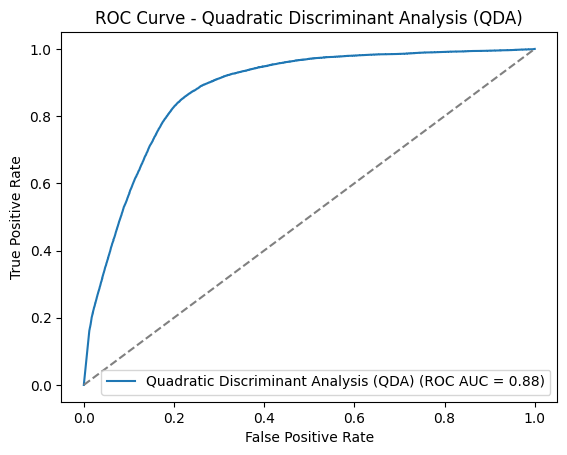

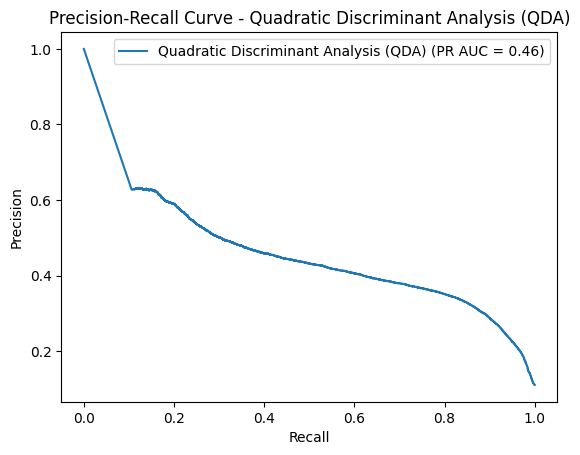

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Re-evaluate saved models
final_results = {}
pr_curves_final = {}
roc_curves_final = {}
for model_name, model in loaded_models.items():
    print(f"\nEvaluating {model_name} on Test Data")

    y_test_proba = model.predict_proba(X_test)[:, 1]  # Assuming predict_proba is available
    y_test_pred = (y_test_proba >= 0.5).astype(int)  # Default threshold 0.5

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_acc = {
        "non_bankrupt": conf_matrix[0, 0] / conf_matrix[0].sum(),
        "bankrupt": conf_matrix[1, 1] / conf_matrix[1].sum()
    }
    pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_test, y_test_proba)
    pr_auc = auc(pr_curve_recall, pr_curve_precision)

    # Store results
    final_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Class Accuracies": class_acc
    }

    # Display metrics
    print(f"\nMetrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  PR AUC: {pr_auc:.4f}")
    print(f"  Class Accuracies: {class_acc}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Bankrupt', 'Bankrupt'],
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Plot PR Curve
    plt.figure()
    plt.plot(pr_curve_recall, pr_curve_precision, label=f"{model_name} (PR AUC = {pr_auc:.2f})")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()


#Feature Importance

                                              Feature  Importance
6   Profitability Ratios (Return on Investment) Gr...    0.041056
7   Profitability Ratios (Return on Investment) Gr...    0.024029
37  Activity Ratios (Assets Turnover) Sales/total ...    0.021713
36  Activity Ratios (Assets Turnover) Sales/total ...    0.019266
39  Activity Ratios (Assets Turnover) Sales/Total ...    0.015780
43  Long-Term Debt-to-Total-Assets Ratio last year -1    0.015580
3   Profitability Ratios (Return on Investment) Ne...    0.015210
41  Activity Ratios (Assets Turnover) Sales/Total ...    0.012461
38  Activity Ratios (Assets Turnover) Sales/total ...    0.011887
40  Activity Ratios (Assets Turnover) Sales/Total ...    0.010463
4   Profitability Ratios (Return on Investment) Ne...    0.007319
42  Long-Term Debt-to-Total-Assets Ratio last avai...    0.005742
44  Long-Term Debt-to-Total-Assets Ratio last year -2    0.005444
15  Structure Ratios (Total-Assets-Structure Ratio...    0.004410
54        

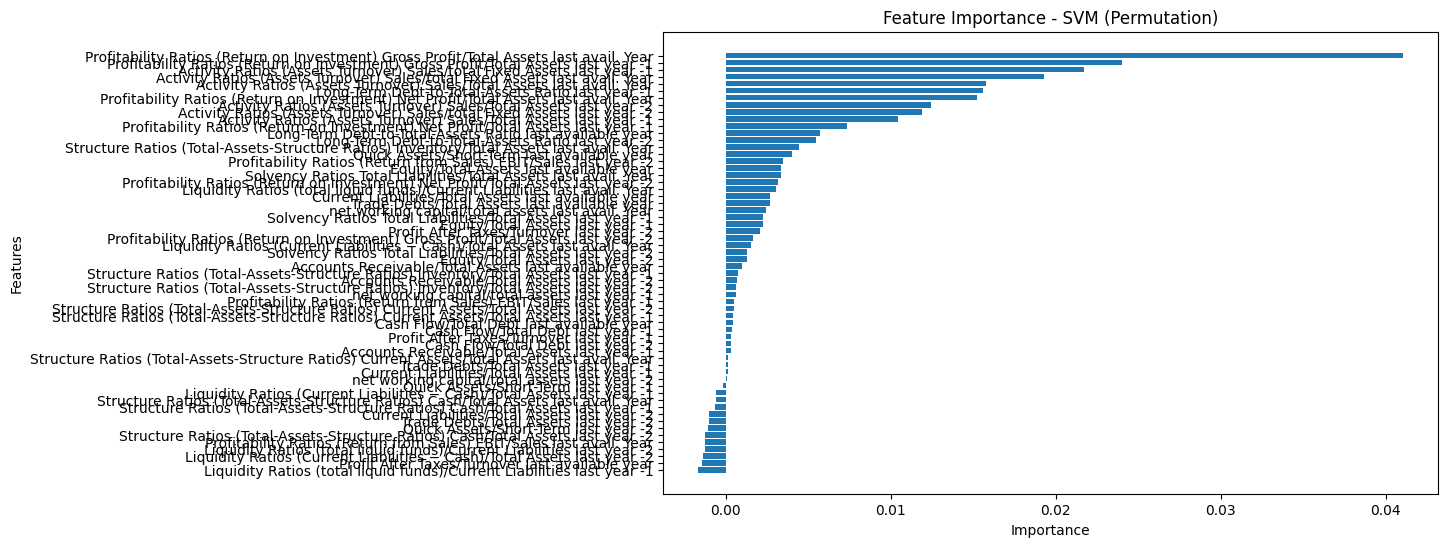

In [11]:
from sklearn.inspection import permutation_importance

# Assuming 'loaded_models' contains the trained model
model = loaded_models["Quadratic Discriminant Analysis (QDA)"]

# Compute permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # Highest importance on top
plt.title("Feature Importance - SVM (Permutation)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()
